<a href="https://colab.research.google.com/github/sagar282004/Battery-Management-System-to-Estimate-the-SOC-of-an-EV-Cell/blob/main/BMS_Updated_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

       Time   Current   Voltage  Temperature
0  0.000000  2.158704  2.999607    26.384377
1  1.000000  2.287674  2.999407    26.227879
2  2.000000  2.228280  2.999757    26.449251
3  2.999992  2.224886  2.999857    26.277494
4  4.000000  2.134946  2.999958    26.380539
       Time   Current   Voltage  Temperature
0  0.000000  2.360728  2.999311    27.449894
1  1.000008  2.303036  2.999813    27.724861
2  2.000008  2.284371  2.999863    27.545357
3  3.000008  2.221588  2.999863    27.457523
4  4.000008  2.158805  2.999813    27.484249


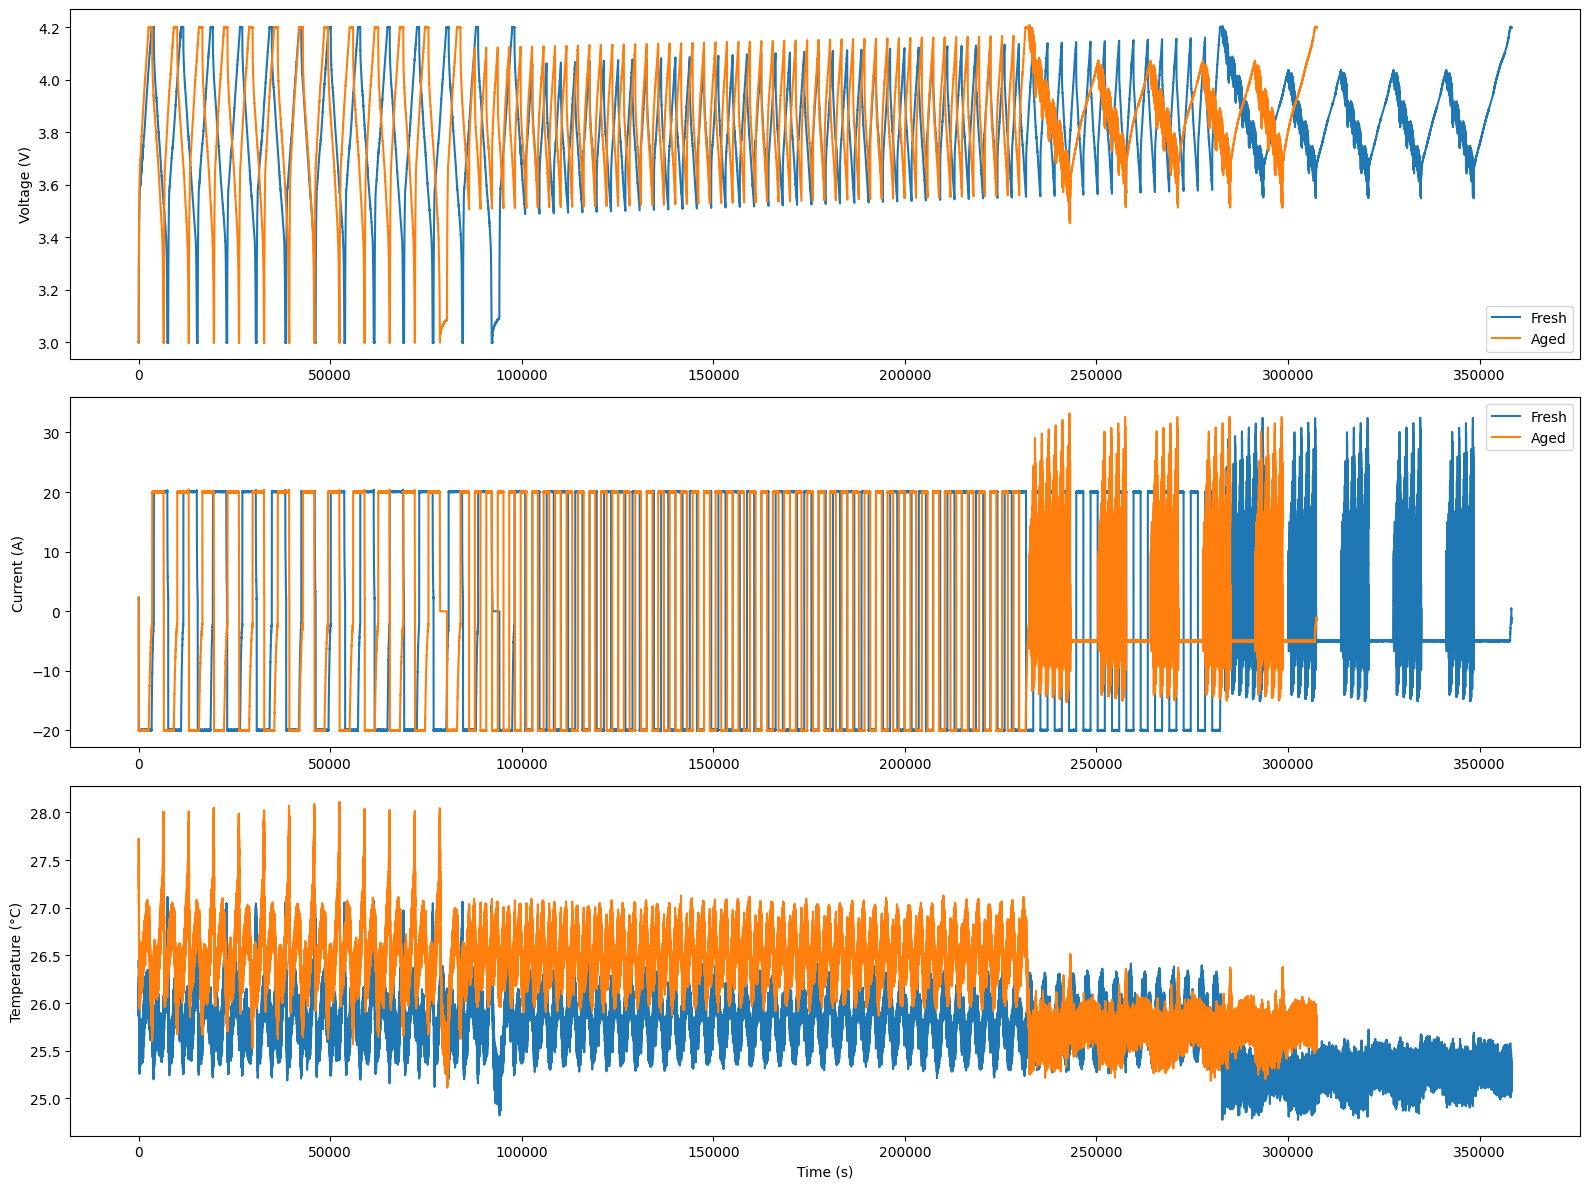

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
aged_df = pd.read_csv('/content/bms_ev/Experimental_data_aged_cell.csv')
fresh_df = pd.read_csv('/content/bms_ev/Experimental_data_fresh_cell.csv')

# Quick check
print(fresh_df.head())
print(aged_df.head())

# Time-series visualization
fig, ax = plt.subplots(3, 1, figsize=(16, 12))
ax[0].plot(fresh_df['Time'], fresh_df['Voltage'], label='Fresh')
ax[0].plot(aged_df['Time'], aged_df['Voltage'], label='Aged')
ax[0].set_ylabel('Voltage (V)')
ax[0].legend()
ax[1].plot(fresh_df['Time'], fresh_df['Current'], label='Fresh')
ax[1].plot(aged_df['Time'], aged_df['Current'], label='Aged')
ax[1].set_ylabel('Current (A)')
ax[1].legend()
ax[2].plot(fresh_df['Time'], fresh_df['Temperature'], label='Fresh')
ax[2].plot(aged_df['Time'], aged_df['Temperature'], label='Aged')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

# Enhanced SoC with smart initial SoC estimation
def estimate_soc_improved(df, nominal_capacity_Ah=2.0, initial_soc=None):
    dt = df['Time'].diff().fillna(0)
    charge_delta = df['Current'] * dt / 3600.0
    if initial_soc is None:
        initial_voltage = df['Voltage'].iloc[0]
        if initial_voltage > 4.1: initial_soc = 1.0
        elif initial_voltage > 3.9: initial_soc = 0.8
        elif initial_voltage > 3.7: initial_soc = 0.6
        elif initial_voltage > 3.5: initial_soc = 0.4
        elif initial_voltage > 3.3: initial_soc = 0.2
        else: initial_soc = 0.1
    cum_charge = charge_delta.cumsum()
    soc = initial_soc - (cum_charge / nominal_capacity_Ah)
    return soc.clip(0, 1)

# Improved internal resistance with smoothing
def estimate_internal_resistance_improved(df, window_length=5, polyorder=2):
    voltage_smooth = savgol_filter(df['Voltage'], window_length, polyorder)
    current_smooth = savgol_filter(df['Current'], window_length, polyorder)
    dV = np.diff(voltage_smooth)
    dI = np.diff(current_smooth)
    with np.errstate(divide='ignore', invalid='ignore'):
        r_internal = dV / dI
        valid_mask = (np.isfinite(r_internal) & (r_internal > 0) & (r_internal < 1.0) & (np.abs(dI) > 0.01))
        r_internal_filtered = np.full(len(df), np.nan)
        r_internal_filtered[1:][valid_mask] = r_internal[valid_mask]
        r_internal_clean = pd.Series(r_internal_filtered).interpolate().fillna(method='bfill').fillna(method='ffill')
        r_internal_smooth = gaussian_filter1d(r_internal_clean, sigma=1.0)
    return r_internal_smooth

# Apply to datasets
fresh_df['estimated_soc_improved'] = estimate_soc_improved(fresh_df)
aged_df['estimated_soc_improved'] = estimate_soc_improved(aged_df)
fresh_df['internal_resistance_improved'] = estimate_internal_resistance_improved(fresh_df)
aged_df['internal_resistance_improved'] = estimate_internal_resistance_improved(aged_df)


/tmp/ipython-input-1788922560.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_internal_clean = pd.Series(r_internal_filtered).interpolate().fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-1788922560.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_internal_clean = pd.Series(r_internal_filtered).interpolate().fillna(method='bfill').fillna(method='ffill')


In [4]:
def add_advanced_features(df):
    df_enhanced = df.copy()
    df_enhanced['voltage_derivative'] = np.gradient(df['Voltage'], df['Time'])
    df_enhanced['voltage_derivative_smooth'] = savgol_filter(df_enhanced['voltage_derivative'], 5, 2)
    df_enhanced['current_derivative'] = np.gradient(df['Current'], df['Time'])
    df_enhanced['current_derivative_smooth'] = savgol_filter(df_enhanced['current_derivative'], 5, 2)
    df_enhanced['temperature_gradient'] = np.gradient(df['Temperature'], df['Time'])
    df_enhanced['temperature_gradient_smooth'] = savgol_filter(df_enhanced['temperature_gradient'], 5, 2)
    df_enhanced['power'] = df['Voltage'] * df['Current']
    df_enhanced['power_smooth'] = savgol_filter(df_enhanced['power'], 5, 2)
    df_enhanced['voltage_current_ratio'] = df['Voltage'] / (np.abs(df['Current']) + 0.001)
    window = 10
    df_enhanced['voltage_ma'] = df['Voltage'].rolling(window=window, center=True).mean()
    df_enhanced['current_ma'] = df['Current'].rolling(window=window, center=True).mean()
    df_enhanced['temperature_ma'] = df['Temperature'].rolling(window=window, center=True).mean()
    df_enhanced['voltage_deviation'] = df['Voltage'] - df_enhanced['voltage_ma']
    df_enhanced['is_discharging'] = (df['Current'] < -0.1).astype(int)
    df_enhanced['is_charging'] = (df['Current'] > 0.1).astype(int)
    df_enhanced = df_enhanced.fillna(method='bfill').fillna(method='ffill')
    return df_enhanced

fresh_df_enhanced = add_advanced_features(fresh_df)


/tmp/ipython-input-2986425995.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_enhanced = df_enhanced.fillna(method='bfill').fillna(method='ffill')


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_cols = [
    'Voltage', 'Current', 'Temperature',
    'voltage_derivative_smooth', 'current_derivative_smooth', 'temperature_gradient_smooth',
    'power_smooth', 'voltage_current_ratio', 'voltage_deviation',
    'is_discharging', 'is_charging'
]
target_col = 'estimated_soc_improved'

X = fresh_df_enhanced[feature_cols].fillna(fresh_df_enhanced[feature_cols].mean())
y = fresh_df_enhanced[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

for name, model in models.items():
    if name == "Linear Regression":
        model.fit(X_train_scaled, y_train)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, scoring=rmse_scorer, cv=kf)
        score = model.score(X_test_scaled, y_test)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        cv_scores = cross_val_score(model, X_train, y_train, scoring=rmse_scorer, cv=kf)
        score = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
    print(f"{name} -- R²: {score:.4f}, Avg CV RMSE: {abs(np.mean(cv_scores)):.4f}")


Random Forest -- R²: 0.9520, Avg CV RMSE: 0.0355
Gradient Boosting -- R²: 0.9516, Avg CV RMSE: 0.0355
Linear Regression -- R²: 0.4658, Avg CV RMSE: 0.1174
Decision Tree -- R²: 0.9085, Avg CV RMSE: 0.0487


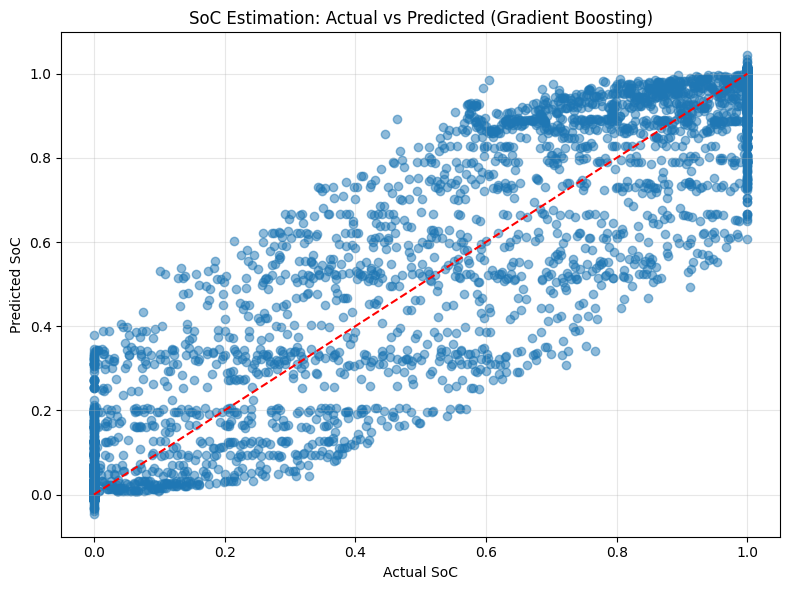

In [7]:
import matplotlib.pyplot as plt

# Use the best model, e.g., Gradient Boosting
best_model = GradientBoostingRegressor(random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual SoC")
plt.ylabel("Predicted SoC")
plt.title("SoC Estimation: Actual vs Predicted (Gradient Boosting)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
